In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
df=pd.read_csv("results/AP_result.csv",)

In [48]:
df.head(3)

,type,APaverage,AP50,AP75,APsmall,APmedium,APlarge,ARdet1,ARdet10,ARdet100,ARsmall,ARmedium,ARlarge
0,h_1,0.056,0.088,0.061,0.006,0.052,0.108,0.057,0.066,0.066,0.005,0.058,0.136
1,h_3,0.056,0.089,0.061,0.005,0.050,0.113,0.060,0.069,0.069,0.005,0.060,0.150
2,h_5,0.031,0.050,0.033,0.003,0.029,0.068,0.034,0.039,0.039,0.002,0.034,0.092


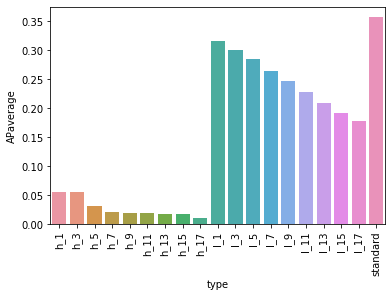

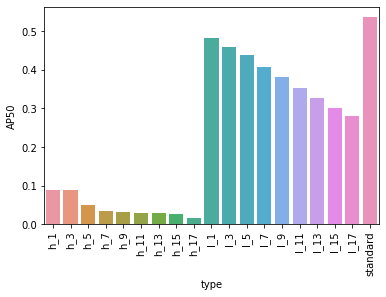

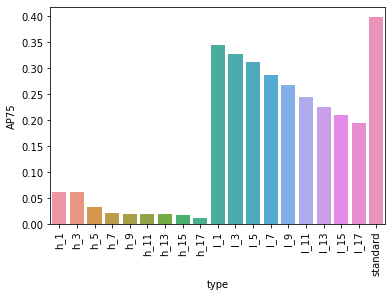

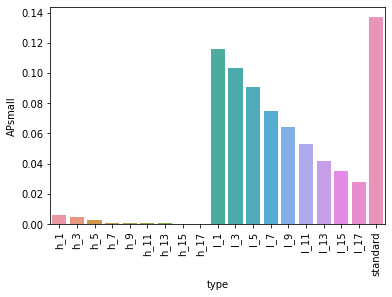

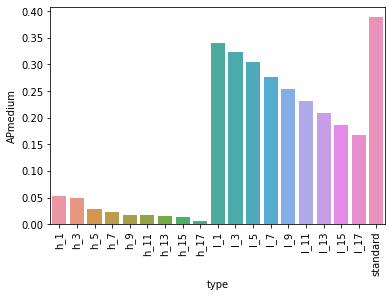

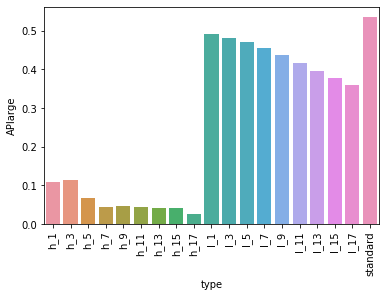

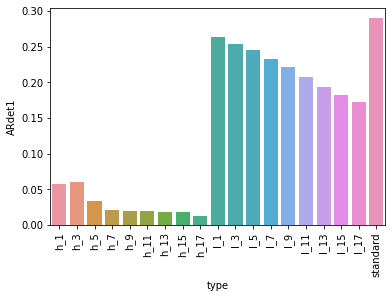

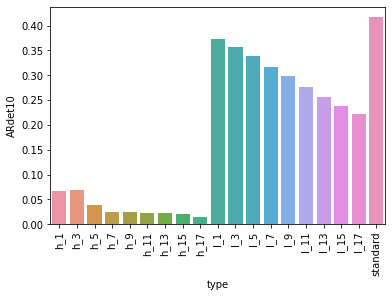

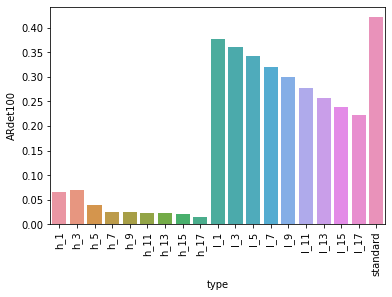

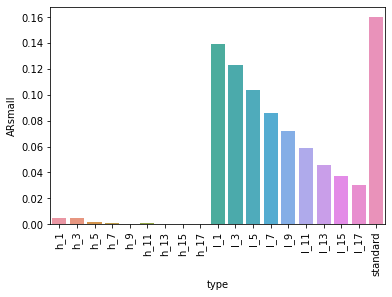

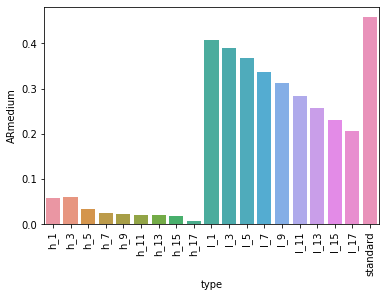

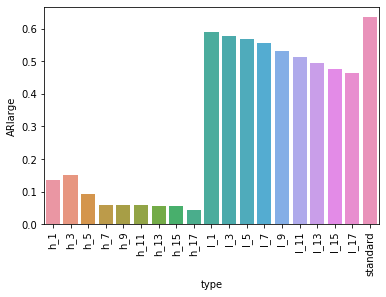

In [61]:
list_of_metric=list(df.columns)[1:]
for x in list_of_metric:
    plt.figure
    ax=sns.barplot(data=df, x="type", y=x)
    ax.tick_params(axis='x',rotation=90)
    plt.show()



In [102]:
import os
import cv2
import copy
import time
import glob
import random
import datetime
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
import sys
sys.path
sys.path.append('../')
print(sys.path)
import pprint
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as T

import skimage.io
import skimage.transform
import skimage.color
import skimage



['C:\\Users\\admin\\Documents\\GitHub\\2021-AI-Highly-Cluttered-Dataset\\metric_hyun', 'C:\\Users\\admin\\anaconda3\\python37.zip', 'C:\\Users\\admin\\anaconda3\\DLLs', 'C:\\Users\\admin\\anaconda3\\lib', 'C:\\Users\\admin\\anaconda3', '', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\admin\\.ipython', '../', '../']


In [103]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [104]:
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO


class Customized_CoCDetection(CocoDetection):
    def __init__(self, root, annFile, transform,kernel_size=5,high=None,low=None):
        super().__init__(root, annFile=annFile)
        self.kernel_size=kernel_size
        self.high=high
        self.low=low
        self.transforms = transform
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]["file_name"]
        bgr_img = cv2.imread(os.path.join(self.root, path))
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        return rgb_img

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    def _lff(self,img,k=1):
        lpf_img =cv2.GaussianBlur(img,(k,k),sigmaX=0,sigmaY=0,borderType=cv2.BORDER_DEFAULT)
        return lpf_img
    def _hff(self,img,k=1):
        img = cv2.Laplacian(img,cv2.CV_8U,ksize=k)
        return img
    
    def __getitem__(self, index: int):
        img_id = self.ids[index]
        image = self._load_image(img_id)
        ori_image=image.copy()
        if self.high:
            image=self._hff(image,self.kernel_size)
        elif self.low:
            image=self._lff(image,self.kernel_size)
        
        coco_annotation = self._load_target(img_id)
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels=[]
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            labels.append(coco_annotation[i]['category_id'])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        labels = torch.tensor([labels])                          
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        #return image,my_annotation
        if self.transforms is not None:
            image, my_annotation = self.transforms(image, my_annotation)
        else:
            image=T.ToTensor()(image)
        


        return image, my_annotation#,ori_image

In [105]:
BASE_IMG_PATH = 'D:/Dataset/Coco/'
BASE_ANN_PATH = 'D:/Dataset/Coco/annotations'

VALID_IMG_PATH = os.path.join(BASE_IMG_PATH, 'val2017')

VALID_ANN_PATH = os.path.join(BASE_ANN_PATH, 'instances_val2017.json')
hf_data_set=Customized_CoCDetection(root=VALID_IMG_PATH,
                                       annFile=VALID_ANN_PATH,
                                        kernel_size=1,
                                       transform=None,
                                       high=None)


loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


In [136]:
import types
def my_summarize(self):
        COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
        'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
        'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]
        '''
        Compute and display summary metrics for evaluation results.
        Note this functin can *only* be applied on the default parameter setting
        '''
        def _summarize( ap=1, iouThr=None, areaRng='all', maxDets=100,dict_val=None ):
            p = self.params
            iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
            titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
            typeStr = '(AP)' if ap==1 else '(AR)'
            iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
                if iouThr is None else '{:0.2f}'.format(iouThr)

            aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
            mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
            if ap == 1:
                # dimension of precision: [TxRxKxAxM]
                s = self.eval['precision']
                # IoU
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,:,aind,mind]
            else:
                # dimension of recall: [TxKxAxM]
                s = self.eval['recall']
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,aind,mind]
            if len(s[s>-1])==0:
                mean_s = -1
            else:
                mean_s = np.mean(s[s>-1])

                #cacluate AP(average precision) for each category
                num_classes = 100
                avg_ap = 0.0
                if ap == 1:
                    for i in range(0, num_classes):
                        dict_val[COCO_INSTANCE_CATEGORY_NAMES[i]]=np.mean(s[:,:,i,:])
                     #   print('category : {0} : {1}'.format(COCO_INSTANCE_CATEGORY_NAMES[i],np.mean(s[:,:,i,:])))
                        avg_ap +=np.mean(s[:,:,i,:])
                    print('(all categories) mAP : {}'.format(avg_ap / num_classes))

            print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
            return mean_s,dict_val
        def _summarizeDets():
            stats = np.zeros((12,))
            dict_list=dict()
            stats[0],dict_val = _summarize(ap=1,dict_val=dict_list)
            #stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
            #stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
            #stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
            #stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
            #stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
            #stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
            #stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
            #stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
            #stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
            #stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
            #stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
            return stats,dict_val
        def _summarizeKps():
            stats = np.zeros((10,))
            stats[0] = _summarize(1, maxDets=20)
            stats[1] = _summarize(1, maxDets=20, iouThr=.5)
            stats[2] = _summarize(1, maxDets=20, iouThr=.75)
            stats[3] = _summarize(1, maxDets=20, areaRng='medium')
            stats[4] = _summarize(1, maxDets=20, areaRng='large')
            stats[5] = _summarize(0, maxDets=20)
            stats[6] = _summarize(0, maxDets=20, iouThr=.5)
            stats[7] = _summarize(0, maxDets=20, iouThr=.75)
            stats[8] = _summarize(0, maxDets=20, areaRng='medium')
            stats[9] = _summarize(0, maxDets=20, areaRng='large')
            return stats
        
        iouType = self.params.iouType
        if iouType == 'segm' or iouType == 'bbox':
            summarize,dict_val = _summarizeDets()
        elif iouType == 'keypoints':
            summarize = _summarizeKps
        #self.stats = summarize()
        
        return dict_val

def __str__(self):

    self.summarize()

In [137]:
results=dict()

In [138]:
from pycocotools.cocoeval import COCOeval
import types
import json   
ker_size=[1,3,5,7,9,11,13,15,17]
coco_true = hf_data_set.coco

for i in ker_size:
    coco_pred = coco_true.loadRes('results/{}_lfbbox_results.json'.format(i))
    coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
    coco_eval.summarize = types.MethodType(my_summarize, coco_eval)
    # run COCO evaluation


    #coco_eval.params.catIds =  #person id : 1
    imgIds=sorted(coco_true.getImgIds())
    coco_eval.params.imgIds = imgIds   

    coco_eval.evaluate()
    coco_eval.accumulate()
    dict_val=coco_eval.summarize()


Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.89s).
Accumulating evaluation results...
DONE (t=3.00s).


IndexError: index 80 is out of bounds for axis 2 with size 80

In [129]:
pd.DataFrame.from_dict(results).to_csv("hf_class_result.csv",index=False)

In [135]:
len(dict_val)

72